# Children's Assessment Perfomance Prediction

# Introduction

This challenge is about predicting the performance of children in logics games. This may lead to some interesting results since it is very possible according to psychiatrists that video games could allow to stimulate the brain in a benefitial way.

Through this challenge, you will have some anonymous data about the games that are played by the children on an educational application.

# Import & Get Data

First, let's import the standard python libraries.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

This challenge aims to predict if a child, given his past gaming history will succeed in his next game assessment.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):\
3: the assessment was solved on the first attempt\
2: the assessment was solved on the second attempt\
1: the assessment was solved after 3 or more attempts\
0: the assessment was never solved

In [2]:
# Read data
data = pd.read_csv(r'data\train.csv.zip')

# First insight into the Data

The columns are as follows :

- `event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
- `timestamp` - Client-generated datetime
- `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
- `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
- `title` - Title of the game or video.
- `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [3]:
data.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,3bfd1a65,34abf0a24c2aaf91,2019-08-25 03:15:48.296000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00129856,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
1,db02c830,34abf0a24c2aaf91,2019-08-25 03:15:48.368000+00:00,"{""event_count"":2,""game_time"":41,""event_code"":2...",00129856,2,2025,41,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
2,a1e4395d,34abf0a24c2aaf91,2019-08-25 03:15:48.374000+00:00,"{""description"":""Pull three mushrooms out of th...",00129856,3,3010,41,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
3,f56e0afc,ae691ec5ad5652cf,2019-09-22 16:32:30.575000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00129856,1,2000,0,Bird Measurer (Assessment),Assessment,TREETOPCITY,3.0
4,27253bdc,07dce61ec6fd52ac,2019-09-05 13:52:48.101000+00:00,"{""event_code"": 2000, ""event_count"": 1}",001d0ed0,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682814 entries, 0 to 2682813
Data columns (total 12 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
dtypes: float64(1), int64(3), object(8)
memory usage: 245.6+ MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
event_count,2682814.0,98.826822,128.110648,1.0,25.0,59.0,123.0,2505.0
event_code,2682814.0,3508.690562,680.664562,2000.0,3020.0,4020.0,4035.0,5010.0
game_time,2682814.0,172473.719303,981875.091671,0.0,30508.0,71126.0,149796.0,76653424.0
accuracy_group,2312.0,1.594291,1.262488,0.0,0.0,2.0,3.0,3.0


In [6]:
data[['installation_id','game_session','event_code','title','type','world']].nunique()

installation_id     2312
game_session       64202
event_code            42
title                 44
type                   4
world                  4
dtype: int64

# A closer look on the Dataset

In [7]:
data.groupby(['installation_id','game_session'])['title'].value_counts().head(20)

installation_id  game_session      title                       
00129856         34abf0a24c2aaf91  Mushroom Sorter (Assessment)      3
                 ae691ec5ad5652cf  Bird Measurer (Assessment)        1
001d0ed0         07dce61ec6fd52ac  Welcome to Lost Lagoon!           1
                 171c4da401da063c  Tree Top City - Level 2           1
                 b6dbceab4fdb7c80  Ordering Spheres                  1
                 c046a858e7c8bf03  Mushroom Sorter (Assessment)     64
                 c9051d01294907b3  Ordering Spheres                  1
                 d26232359fbda157  Tree Top City - Level 1           1
                 dc6bc0284039c9fb  Mushroom Sorter (Assessment)      1
                 f254185e012e45a8  Pirate's Tale                     1
00225f67         03828db3ffa51606  Flower Waterer (Activity)       122
                 0861b5e3302ab66e  Tree Top City - Level 3           1
                 1184d3e169326bc5  Bug Measurer (Activity)           3
             

We see that each user (**installation_id**) has multiple game sessions in which they play a particular activity (**title**). For each activity, a different number of events may happen.

We now look further into the different titles in the dataset.

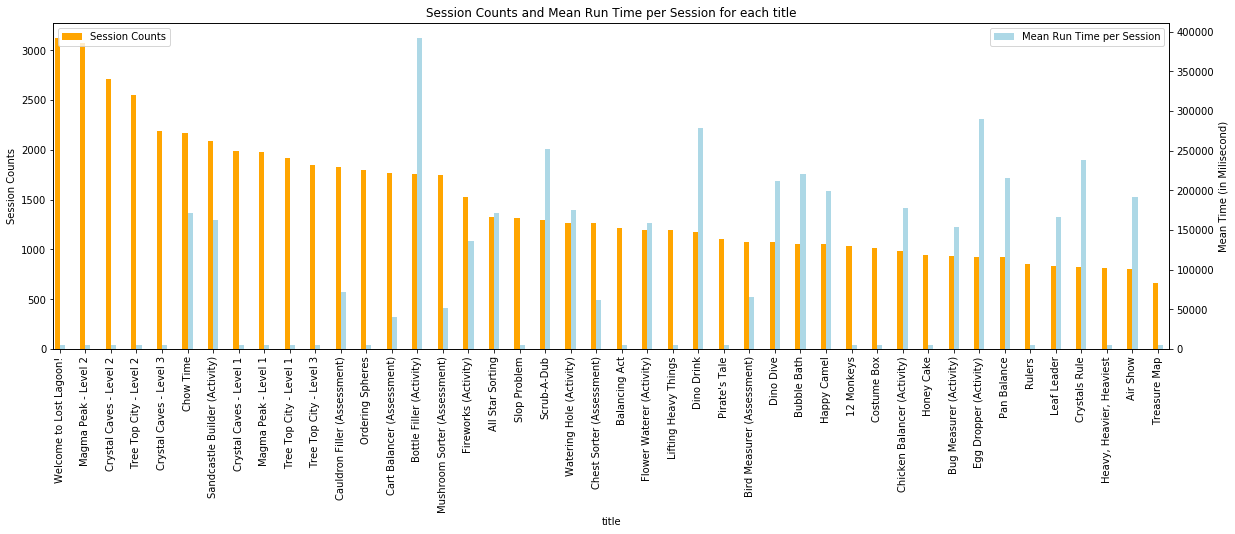

In [8]:
fig = plt.figure(figsize=(20,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

groupby_title = data.groupby(['game_session','title'])['game_time'].agg('max').groupby('title')\
            .agg(['count','mean']).sort_values(by='count',ascending=False)
# If we want to count events
# groupby_title = data.groupby(['game_session','title'])['event_count'].agg('sum').groupby('title')\
#             .agg(['count','mean']).sort_values(by='count',ascending=False)

groupby_title['count'].plot(kind='bar', color='orange', ax=ax, width=width, position=1, label='Session Counts')
# Add 5 seconds to avoid zeros in plot
(5000+groupby_title['mean']).plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, label='Mean Run Time per Session')

ax.set_ylabel('Session Counts')
ax2.set_ylabel('Mean Time (in Milisecond)')

ax.legend(loc='upper left')
ax2.legend()

plt.title('Session Counts and Mean Run Time per Session for each title')
plt.show()

We see that there are many activities that have high session counts but also very low (~0s) run times. They are in fact the activities that require only one, or a few, events to complete. For example, the title **Welcome to Lost Lagoon!** corresponds to the opening scene of the application, hence it has the most number of times played. We also note that the mean run time of each session is no longer than $400 \ 000 \ ms$, or about $6$ minutes.

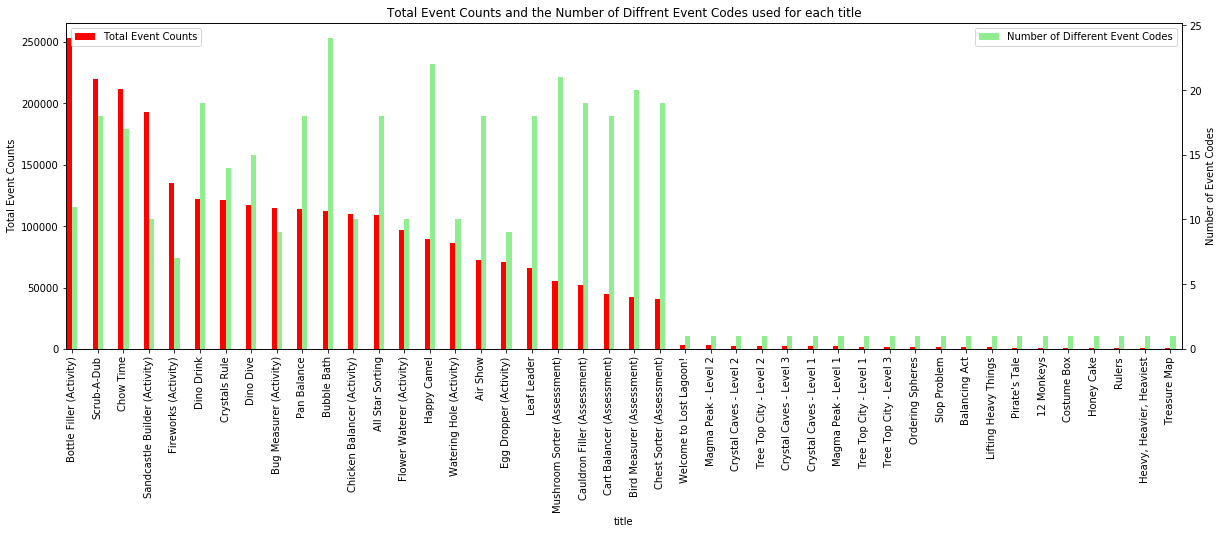

In [9]:
fig = plt.figure(figsize=(20,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

groupby_title = data.groupby('title')['event_code'].agg([pd.Series.nunique,'count'])\
            .sort_values(by='count',ascending=False)

groupby_title['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='Total Event Counts')
groupby_title['nunique'].plot(kind='bar', color='lightgreen', ax=ax2, width=width, position=0, label='Number of Different Event Codes')

ax.set_ylabel('Total Event Counts')
ax2.set_ylabel('Number of Event Codes')

ax.legend(loc='upper left')
ax2.legend()

plt.title('Total Event Counts and the Number of Diffrent Event Codes used for each title')
plt.show()

We see that half of the activities have very few events compared to other activities. If we look at the number of different event codes used for the activities, we see that these activities with low counts correspond to the activities with only one event code. We also notice that the activities with many event codes (meaning that it's more complex to play) tend to have low session counts or mean run time and hence lead to lower event counts.

Let's take a look at the different types of the activities.

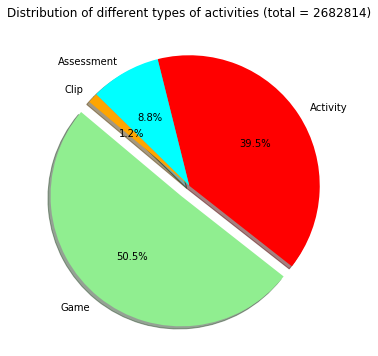

In [10]:
type_counts = data.type.value_counts()
# Data to plot
labels = type_counts.keys()
sizes = type_counts.values
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, 
        colors=['lightgreen', 'red','cyan','orange'],
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of different types of activities (total = %d)' %np.sum(sizes))
plt.show()

As we mentioned earlier, there are 4 types of activities in the application: **Game**, **Activity**, **Assessment** and **Clip**. This plot tells us that most of the time the users play games or do activities with the application, while only a few actually watch clips.

We then take a look at the different worlds.

D:\Anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


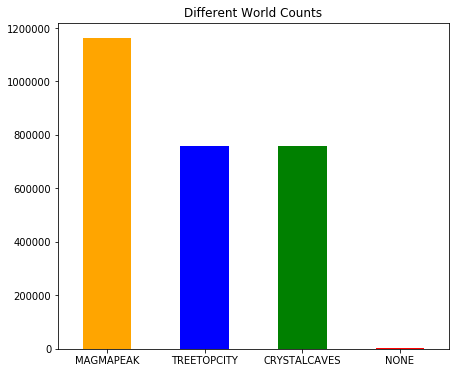

In [11]:
data.world.value_counts()\
        .plot.bar(figsize=(7,6), 
                  title='Different World Counts',
                  colors = ['orange','blue','green','red'], 
                  rot=0)

We see that most of the activities take place in one of these three worlds: **Magmapeak**, **Crystalcaves** and **Treetopcity**. 

We also note that each title happen in only one particular world.

In [12]:
print(data[['title','world']].drop_duplicates().head(10))
len(data[['title','world']].drop_duplicates()) == len(data[['title']].drop_duplicates())

                            title        world
0    Mushroom Sorter (Assessment)  TREETOPCITY
3      Bird Measurer (Assessment)  TREETOPCITY
4         Welcome to Lost Lagoon!         NONE
5         Tree Top City - Level 1  TREETOPCITY
6                Ordering Spheres  TREETOPCITY
8         Tree Top City - Level 2  TREETOPCITY
9                   Pirate's Tale  TREETOPCITY
78               All Star Sorting  TREETOPCITY
200                   Costume Box  TREETOPCITY
201          Fireworks (Activity)  TREETOPCITY


True

In [13]:
world_dict = data.groupby(['world'])['title'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
for world in world_dict:
    print("==============Titles on World " + world + "=================")
    print(", ".join(sorted(world_dict[world])))
    print()

==============Titles on World CRYSTALCAVES=================
Balancing Act, Cart Balancer (Assessment), Chest Sorter (Assessment), Chicken Balancer (Activity), Chow Time, Crystal Caves - Level 1, Crystal Caves - Level 2, Crystal Caves - Level 3, Egg Dropper (Activity), Happy Camel, Heavy, Heavier, Heaviest, Honey Cake, Leaf Leader, Lifting Heavy Things, Pan Balance

==============Titles on World MAGMAPEAK=================
Bottle Filler (Activity), Bubble Bath, Cauldron Filler (Assessment), Dino Dive, Dino Drink, Magma Peak - Level 1, Magma Peak - Level 2, Sandcastle Builder (Activity), Scrub-A-Dub, Slop Problem, Watering Hole (Activity)

==============Titles on World NONE=================
Welcome to Lost Lagoon!

==============Titles on World TREETOPCITY=================
12 Monkeys, Air Show, All Star Sorting, Bird Measurer (Assessment), Bug Measurer (Activity), Costume Box, Crystals Rule, Fireworks (Activity), Flower Waterer (Activity), Mushroom Sorter (Assessment), Ordering Spheres, P

We finally pay attention to the timestamps in the data.

In [14]:
df_times = data.loc[:,['timestamp']]
df_times['timestamp'] = pd.to_datetime(df_times['timestamp'])
df_times['date'] = df_times['timestamp'].dt.date

In [15]:
print("Number of dates in the dataset:",df_times['date'].nunique())
print("First date:",min(df_times['date']))
print("Last date:",max(df_times['date']))

Number of dates in the dataset: 84
First date: 2019-07-23
Last date: 2019-10-14


We see that the data is collected on 84 days from **23/07/2019** to **14/10/2019** (roughly 3 months).

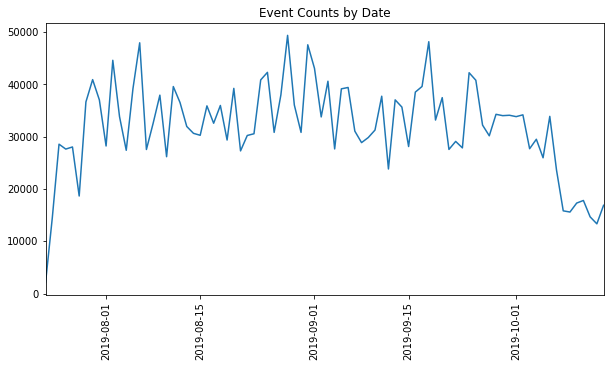

In [16]:
df_times['date'].value_counts().sort_index().plot(figsize=(10,5), rot=90, title = "Event Counts by Date")

Now we are going to plot the number of observations for each day of week and the hour of the day.

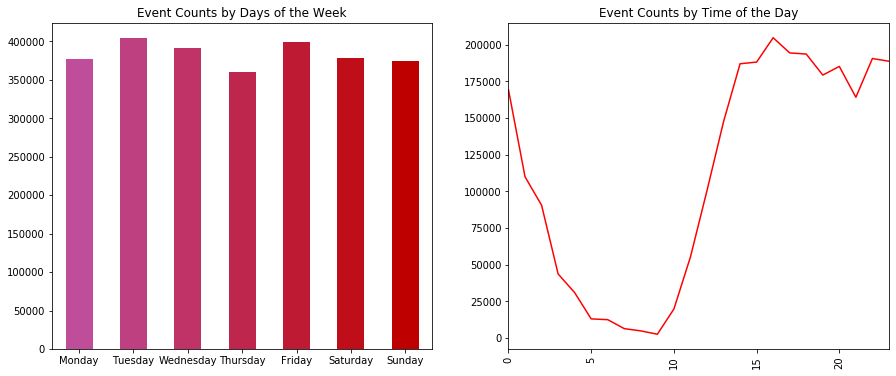

In [17]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_times['timestamp'].dt.weekday_name.value_counts()\
    [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]\
            .plot.bar(
                  title='Event Counts by Days of the Week',
                  color = [(0.75, x/20.0, x/10.0) for x in reversed(range(7))], 
                  rot=0, ax= ax1)

df_times['timestamp'].dt.hour.value_counts().sort_index()\
        .plot(rot=90, title = "Event Counts by Time of the Day", color = 'red')

# Preprocess & Split the data into train/test sets

To have a consistent model we need to split the data into two folders, one for training and another one for testing. We only used the training set from the kaggle competition, in order to access the target data, and we then splitted it in our own public/private and train/test data sets.

We did the same kind of split as the one which is performed in the kaggle competition : a same installation_id cannot exist in several sets, and every installation_id in the test sets must have at least one attempt on an assessment.

In [18]:
def get_train_test(df, test_frac=0.25):
    """
    Splits the dataset into train and test sets according to the challenge procedure
    """

    ids_attempted = df[(df.type == 'Assessment') & \
                       ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                       (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))] \
                       .installation_id.unique()
    test_ids = np.random.choice(ids_attempted, size=int(test_frac * len(ids_attempted)), replace=False)

    train = df[~df.installation_id.isin(test_ids)].reset_index(drop=True)
    test = df[df.installation_id.isin(test_ids)].reset_index(drop=True)

    return train, test

We then need to truncate the histories of each installation_id individually, as it is done in the kaggle competition. It is normally only done on the test dataset, but we choose to also truncate the train sets in the same way so that they are more comparable in order to generalize. Both public and private sets have been truncated.

For each installation_id, we collect the history and truncate at a random attempt which has been made by the user for an assessment. Thus, we delete every subsequent event from the user history, including his performance for that assessment. That performance is the target data which we will have to predict.

The following function allows us to truncate the dataset and collect the target data y before it is deleted from the dataset.

In [19]:
def truncate_and_get_y(df):
    """
    Truncates the dataset randomly for each user, according to the challenge procedure
    Also returns y before the information is lost through the truncation
    """

    # Sort dataframe
    df = df.copy()
    df.timestamp = pd.to_datetime(df.timestamp)
    df.sort_values(['installation_id', 'timestamp'], inplace=True)

    # Filter dataframe
    df_attempts = df[(df.type == 'Assessment') & \
                    ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                     (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))].copy()
    df = df[df.installation_id.isin(df_attempts.installation_id.unique())].copy().reset_index(drop=True)

    # Compute y
    df_attempts['success'] = df_attempts.event_data.apply(lambda x: json.loads(x)['correct']) * 1
    passed = df_attempts.groupby('game_session').success.max().to_frame('passed')
    n_attempts = df_attempts.groupby('game_session').size().to_frame('n_attempts')
    accuracy = pd.Series(0, index=passed.index)
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts > 2)] = 1
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts == 2)] = 2
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts == 1)] = 3

    selected_sessions = df_attempts.groupby('installation_id').game_session\
        .apply(lambda obj: obj.loc[np.random.choice(obj.index)])
    y = pd.Series(accuracy.loc[selected_sessions].values, index=selected_sessions.index)

    # Truncate
    df['idx'] = df.index
    marked_start = df.game_session.isin(selected_sessions) \
        & df.idx.isin(df.groupby('game_session').idx.first())
    marked_start = marked_start[marked_start].index
    marked_end = df.idx.isin(df.groupby('installation_id').idx.last())
    marked_end = marked_end[marked_end].index
    df.drop('idx', axis=1, inplace=True)
    idx = list(range(marked_start[0] + 1))
    for start, end in zip(marked_start[1:], marked_end[:-1]):
        idx += list(range(end + 1, start + 1))
    df = df.loc[idx]

    return df, y

We had to carry out those steps in order to generate the public/private, train/test sets the same way it was done in the kaggle competition, but now that it is done you should not use those functions.

Simply load the data sets we prepared, in the data folder.

Now let's take a look at the labels. As we can see below the labels are not well distributed.

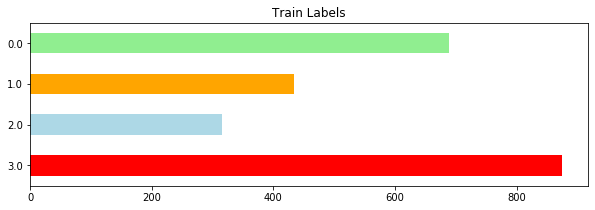

In [20]:
data.accuracy_group.value_counts().sort_index(ascending=False) \
    .plot(kind='barh', figsize=(10, 3), title='Train Labels', color=['r','lightblue','orange','lightgreen'])
plt.show()

# Feature Processing

Preprocessing features : 

- `n_sessions` : number of sessions for each user

- `unique_events_per_session` : mean number of unique events in a session for each user

- `mean_game_time` : mean game time in a session for each user

- `min_hour` : earliest hour played for each user

- `mean_hour` : mean hour played for each user

- `max_hour` : latest hour played for each user

- `most_played_dayofweek` : most played day of the week for each user

- `first_day` : the day the user first played, for each user

- `median_day` : the median day the user has played, for each user

- `hour` : the hour at the time the assessment we want to predict has occurred

- `dayofweek` : the day of the week at the time the assessment we want to predict has occurred

- `day` : the day at the time the assessment we want to predict has occurred

- `total_days` : the number of different days the user has played before the assessment we want to predict occurred

- `prediction_assessment_{title}`: whether the assessment we have to predict is this title or not, for each user

- `prediction_world_{title}`: whether the assessment we have to predict belongs to that world or not, for each user

- `type_{type}`: the number of times the user has played a title belonging to that type can be 'Assessment', 'Game', 'Clip' or 'Activity'

- `world_{world}` : the number of times the user has played a title belonging to that world can be 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES' or 'NONE'

- `n_events_per_session_{event_code}` : the mean number of times a given event_code has occurred per game session, for that user

- `mean_passed`: percentage of the assessments passed among the attempted assessments for each user

- `mean_attempts`: mean number of attempts among the attempted assessments for each user

- `max_attempts`: maximum number of attempts among the attempted assessments for each user

- `n_sessions_{title}` : number of sessions of a given title, for each user

- `unique_events_{title}`: mean number of unique events happening in a session of a given title, for each user

- `game_time_{title}`: mean game time in a session of a given title, for each user

- `mean_passed_{title}`: percentage of the assessments passed among the attempted assessments for a given title, for each user

- `mean_attempts_{title}`: mean number of attempts among the attempted assessments for a given title, for each user

- `max_attempts_{title}`: maximum number of attempts among the attempted assessments for a given title, for each user

This is our starting proposition for the FeatureExtractor class:

In [21]:
class FeatureExtractor:

    def __init__(self):
        self.train_cols = None

    def fit(self, X, y):
        pass

    def transform(self, X):
        """
        Preprocesses the dataset
        """

        # Clean dataset
        df = X.copy()
        df.timestamp = pd.to_datetime(df.timestamp)
        df['hour'] = df.timestamp.dt.hour
        df['dayofweek'] = df.timestamp.dt.dayofweek
        df['dayofyear'] = df.timestamp.dt.dayofyear
        df_attempts = df[(df.type == 'Assessment') & \
                        ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                        (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))].copy()
        df_attempts['success'] = df_attempts.event_data.apply(lambda x: json.loads(x)['correct']) * 1
        passed = df_attempts.groupby(['installation_id', 'game_session']).success.max()\
            .to_frame('passed').reset_index()
        n_attempts = df_attempts.groupby(['installation_id', 'game_session']).size()\
            .to_frame('n_attempts').reset_index()
    
        # Build features
        # General user features
        X = pd.DataFrame()
        X['n_sessions'] = df.groupby('installation_id').game_session.nunique()
        X['unique_events_per_session'] = df.groupby('installation_id').size()
        X.unique_events_per_session /= X.n_sessions
        game_time = df.groupby(['installation_id', 'game_session']).game_time.max().reset_index()
        X['mean_game_time'] = game_time.groupby('installation_id').game_time.mean()
    
        # Time user features
        hour = df.groupby(['installation_id', 'game_session']).hour.first().reset_index()
        X['min_hour'] = hour.groupby('installation_id').hour.min()
        X['mean_hour'] = hour.groupby('installation_id').hour.mean()
        X['max_hour'] = hour.groupby('installation_id').hour.max()
        dayofweek_count = df.groupby(['installation_id', 'dayofweek'])\
            .game_session.nunique().to_frame('count').reset_index()
        dayofweek_count.sort_values(['installation_id', 'count'], inplace=True)
        X['most_played_dayofweek'] = dayofweek_count.groupby('installation_id').dayofweek.last()
        X['first_day'] = df.groupby('installation_id').dayofyear.min()
        different_days = df.groupby(['installation_id', 'dayofyear']).size().reset_index()
        X['median_day'] = different_days.groupby('installation_id').dayofyear.median()
    
        X['hour'] = df.groupby('installation_id').hour.last()
        X['dayofweek'] = df.groupby('installation_id').dayofweek.last()
        X['day'] = df.groupby('installation_id').dayofyear.last()
        X['total_days'] = df.groupby('installation_id').dayofyear.nunique()
    
        # Predicted game features
        prediction_assessment = df.groupby('installation_id').title.last()\
            .to_frame('last').reset_index()
        prediction_assessment['occurred'] = 1
        prediction_assessment = prediction_assessment\
            .pivot(index='installation_id', columns='last', values='occurred').fillna(0)
        prediction_assessment.columns = ['prediction_assessment_{}'.format(c) 
                                        for c in prediction_assessment.columns]
        X = X.merge(prediction_assessment, how='left', left_index=True, right_index=True)

        prediction_world = df.groupby('installation_id').world.last()\
            .to_frame('last').reset_index()
        prediction_world['occurred'] = 1
        prediction_world = prediction_world\
            .pivot(index='installation_id', columns='last', values='occurred').fillna(0)
        prediction_world.columns = ['prediction_world_{}'.format(c) 
                                        for c in prediction_world.columns]
        X = X.merge(prediction_world, how='left', left_index=True, right_index=True)
    
        # Gameplay user features
        type_counts = df.groupby(['installation_id', 'type']).game_session.nunique()\
            .reset_index().pivot(index='installation_id', columns='type', values='game_session').fillna(0)
        type_counts.columns = ['type_{}'.format(c) for c in type_counts.columns]
        X = X.merge(type_counts, how='left', left_index=True, right_index=True)
    
        world_counts = df.groupby(['installation_id', 'world']).game_session.nunique()\
            .reset_index().pivot(index='installation_id', columns='world', values='game_session').fillna(0)
        world_counts.columns = ['world_{}'.format(c) for c in world_counts.columns]
        X = X.merge(world_counts, how='left', left_index=True, right_index=True)
    
        event_counts = df.groupby(['installation_id', 'event_code']).event_count.sum()\
            .reset_index().pivot(index='installation_id', columns='event_code', values='event_count').fillna(0)
        event_counts = event_counts.div(X.n_sessions, axis=0)
        event_counts.columns = ['n_events_per_session_{}'.format(c) for c in event_counts.columns]
        X = X.merge(event_counts, how='left', left_index=True, right_index=True)
    
        # Success user features
        X['mean_passed'] = passed.groupby('installation_id').passed.mean()
        X.mean_passed.fillna(-1, inplace=True)
        X['mean_attempts'] = n_attempts.groupby('installation_id').n_attempts.mean()
        X['max_attempts'] = n_attempts.groupby('installation_id').n_attempts.max()
        X.fillna(0, inplace=True)
    
        # General user features for each title
        title_sessions = df.groupby(['installation_id', 'title']).game_session.nunique()\
            .reset_index().pivot(index='installation_id', columns='title', values='game_session').fillna(0)
        title_unique_events = df.groupby(['installation_id', 'title']).size().to_frame('size')\
            .reset_index().pivot(index='installation_id', columns='title', values='size')
        title_unique_events  = (title_unique_events / title_sessions).fillna(0)
        title_sessions.columns = ['n_sessions_{}'.format(c) for c in title_sessions.columns]
        title_unique_events.columns = ['unique_events_{}'.format(c) for c in title_unique_events.columns]
        X = X.merge(title_sessions, how='left', left_index=True, right_index=True)
        X = X.merge(title_unique_events, how='left', left_index=True, right_index=True)
    
        game_time = df.groupby(['installation_id', 'title', 'game_session']).game_time.max().reset_index()
        title_times = game_time.groupby(['installation_id', 'title']).game_time.mean()\
            .reset_index().pivot(index='installation_id', columns='title', values='game_time').fillna(0)
        title_times.columns = ['game_time_{}'.format(c) for c in title_times.columns]
        X = X.merge(title_times, how='left', left_index=True, right_index=True)
    
        # Success user features for each assessment
        passed = df_attempts.groupby(['installation_id', 'title', 'game_session']).success.max()\
            .to_frame('passed').reset_index()
        n_attempts = df_attempts.groupby(['installation_id', 'title', 'game_session']).size()\
            .to_frame('n_attempts').reset_index()
        title_passed = passed.groupby(['installation_id', 'title']).passed.mean().to_frame('mean')\
            .reset_index().pivot(index='installation_id', columns='title', values='mean')
        title_passed.columns = ['mean_passed_{}'.format(c) for c in title_passed.columns]
        X = X.merge(title_passed, how='left', left_index=True, right_index=True).fillna(-1)
    
        title_mean_attempts = n_attempts.groupby(['installation_id', 'title'])\
            .n_attempts.mean().to_frame('mean')\
            .reset_index().pivot(index='installation_id', columns='title', values='mean')
        title_mean_attempts.columns = ['mean_attempts_{}'.format(c) for c in title_mean_attempts.columns]
        X = X.merge(title_mean_attempts, how='left', left_index=True, right_index=True).fillna(0)
    
        title_max_attempts = n_attempts.groupby(['installation_id', 'title'])\
            .n_attempts.max().to_frame('max')\
            .reset_index().pivot(index='installation_id', columns='title', values='max')
        title_max_attempts.columns = ['max_attempts_{}'.format(c) for c in title_max_attempts.columns]
        X = X.merge(title_max_attempts, how='left', left_index=True, right_index=True).fillna(0)

        X['n_lines'] = df.groupby('installation_id').size()

        # Drop columns with only 1 modality
        if self.train_cols is None:
            X = X.loc[:, X.nunique() != 1]
            self.train_cols = X.columns
        else:
            X = X.loc[:, self.train_cols]
    
        return X

In [22]:
# Extract features
test = pd.read_csv(r'data\test.csv.zip')
X_train, y_train = data.drop('accuracy_group', axis=1), data.accuracy_group.fillna(-1)
X_test, y_test = test.drop('accuracy_group', axis=1), test.accuracy_group.fillna(-1)

extractor = FeatureExtractor()
X_train = extractor.transform(X_train)
X_test = extractor.transform(X_test)

In [23]:
X_train.shape

(2312, 201)

In [24]:
X_train.head()

,n_sessions,unique_events_per_session,mean_game_time,min_hour,mean_hour,max_hour,most_played_dayofweek,first_day,median_day,hour,...,mean_attempts_Cart Balancer (Assessment),mean_attempts_Cauldron Filler (Assessment),mean_attempts_Chest Sorter (Assessment),mean_attempts_Mushroom Sorter (Assessment),max_attempts_Bird Measurer (Assessment),max_attempts_Cart Balancer (Assessment),max_attempts_Cauldron Filler (Assessment),max_attempts_Chest Sorter (Assessment),max_attempts_Mushroom Sorter (Assessment),n_lines
installation_id,,,,,,,,,,,,,,,,,,,,,
00129856,2,2.000000,20.500000,3,9.500000,16,6,237,251.0,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
001d0ed0,8,8.875000,6474.750000,13,13.000000,13,3,248,248.0,13,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,71
00225f67,18,33.611111,30756.277778,0,15.333333,23,5,278,278.5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605
00279ac5,43,58.162791,105595.813953,13,14.674419,18,4,221,221.0,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2501
003372b0,41,28.926829,35727.146341,13,13.000000,13,3,269,269.0,13,...,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1186


### Let's take a brief look at some features!

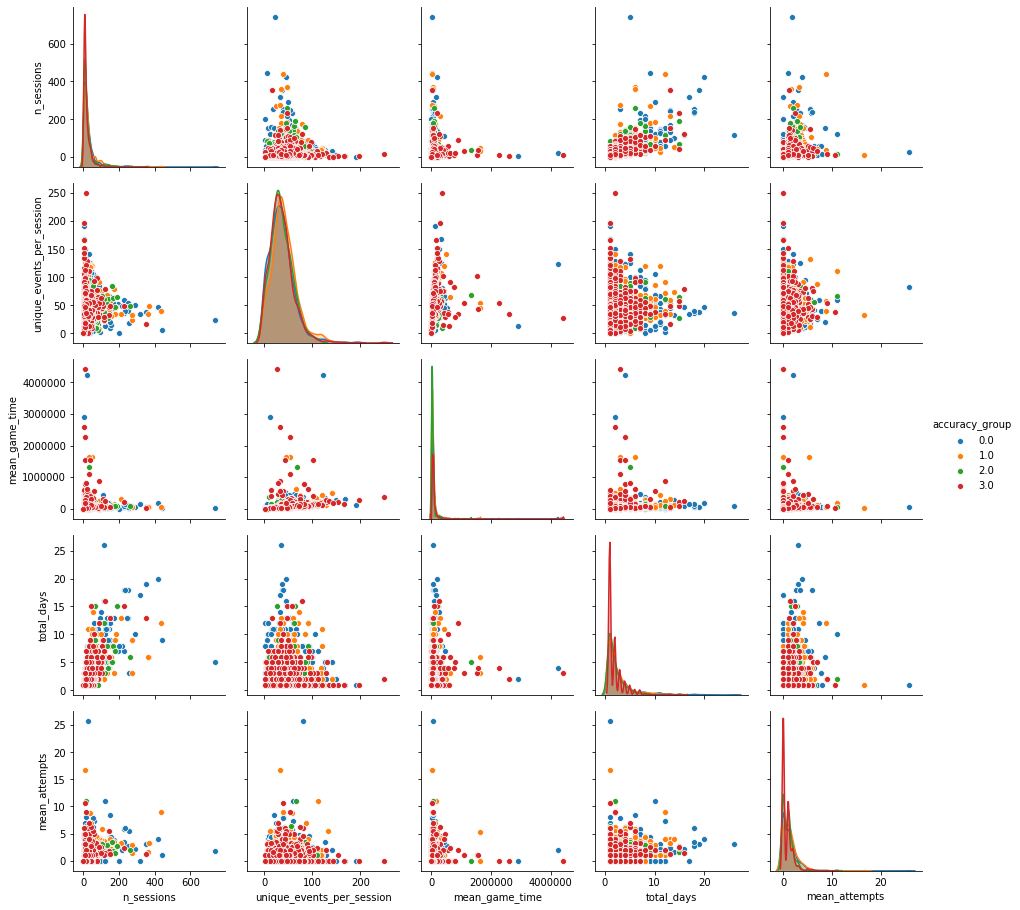

In [25]:
X_train_toplot = X_train[['n_sessions','unique_events_per_session','mean_game_time','total_days','mean_attempts']].copy()
X_train_toplot['accuracy_group'] = y_train[y_train != -1].values
sns.pairplot(X_train_toplot, hue='accuracy_group')

Looking at the distribution of the labels, we can infer that:
* Interestingly, children that spent a lot of time (*n_sessions, mean_game_time, total_days*) playing tend to fail on assessment (with label **0**), or succeed on the first attempt.
* Children that can deal with using many events (*unique_events_per_session*) tend to succeed on the first attempt.
* As long as the children have higher attempts in average (*mean_attempts*), they tend to answer less correctly.

Now if we take a look at some pair plots, we can observe some behaviors:
* *total_days* vs *n_sessions*: The longer the children play, the more sessions they have.
* *unique_events_per_session* vs *total_days*: The more complex the games are, the less days the children play on.
* *unique_events_per_session* vs *mean_attempts*: The more smart the children are, the less attempts they make.

# Model and feature importance

This is our starting proposition of the Classifier class:

In [26]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier as RFC

class Classifier(BaseEstimator):
    def __init__(self, clf=None):
        self.clf = RFC(n_estimators=14, max_depth=18, max_features=150)
        if clf is not None:
            self.clf = clf

    def fit(self, X, y):
        y = y.fillna(-1)
        y_reduced_format = y[y != -1]
        self.clf.fit(X, y_reduced_format)

    def predict_proba(self, X):
        n_lines = X.n_lines.values
        preds_reduced_format = self.clf.predict_proba(X)
        preds_reduced_format = np.hstack([np.zeros((preds_reduced_format.shape[0], 1)), preds_reduced_format])

        n_classes = preds_reduced_format.shape[1]
        preds_extended_format = np.zeros((n_lines.sum(), n_classes)) + 1 / n_classes
        idx = np.cumsum(n_lines)
        preds_extended_format[idx - 1] = preds_reduced_format
        
        return preds_extended_format

    def predict(self, X):
        n_lines = X.n_lines.values
        preds_reduced_format = self.clf.predict(X)

        preds_extended_format = np.zeros(n_lines.sum()) - 1
        idx = np.cumsum(n_lines)
        preds_extended_format[idx - 1] = preds_reduced_format
        
        return preds_extended_format

In [27]:
model = Classifier()
model.fit(X_train, y_train)

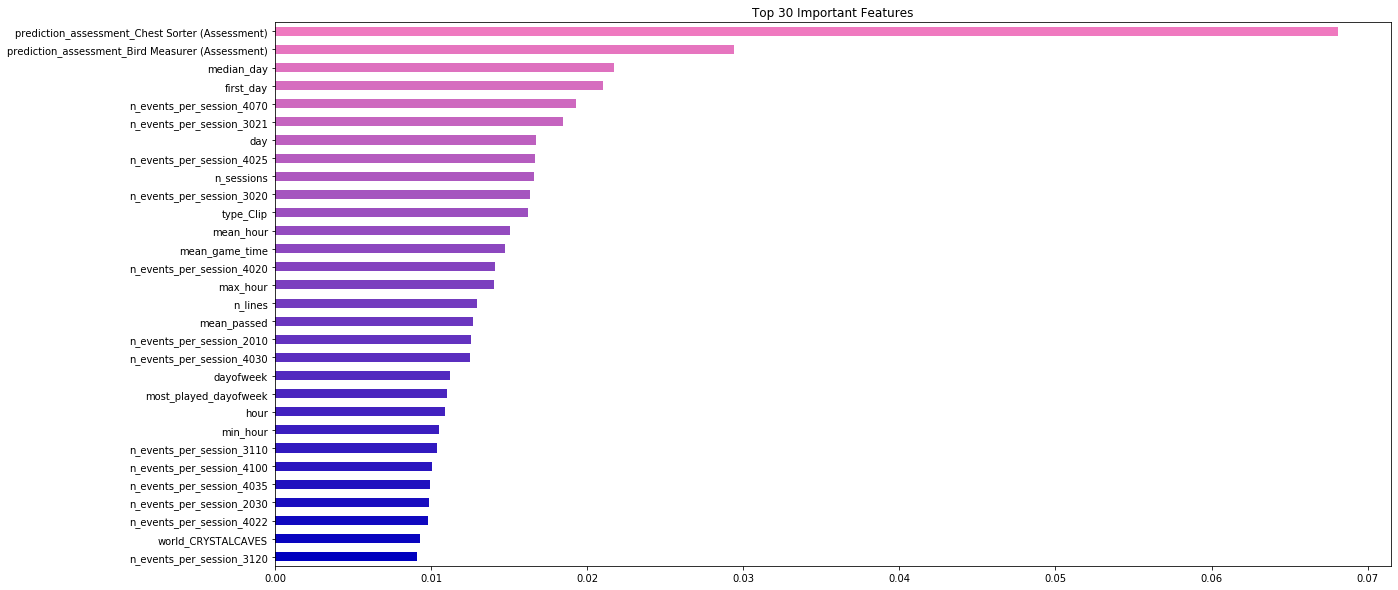

In [28]:
feat_importances = pd.Series(model.clf.feature_importances_, index=X_train.columns)
n_take =30
feat_importances.nlargest(n_take).sort_values(ascending=True)\
        .plot(figsize=(20,10),
              kind='barh',
              color = [(x/(n_take+1), x/(2*n_take+1), 0.75) for x in range(n_take)],
                 title = 'Top %d Important Features' %n_take)

We see that the number of occurences of some events like the event 4070 are important in order to predict the performance of the children.

More importantly, it is crucial to use the information on which assessment the user is facing since the Bird Measurer and Chest Sorter assessments are significantly harder (especially the Chest Sorter assessment).

This is why these two features have such a high importance.

In [29]:
preds_test = model.predict(X_test)

In [30]:
score = np.mean(preds_test[y_test != -1] == y_test[y_test != -1])

In [31]:
score

0.5233160621761658

# The Quadratic Weighted Kappa Metric

We also wanted to use in this challenge the quadratic weighted kappa metric since it is the one used in the kaggle competition.

It allows to weight the disagreement between two outcomes. This metric is especially useful when the different classes are ordered.

Formally, let us denote $N$ the number of different classes. The calculation of the quadratic weighted kappa involves three matrices:
* An $N \times N$ weight matrix $W$ which penalizes the disagreements between classes, with:
$$w_{i,j} = \frac{\left(i-j\right)^2}{\left(N-1\right)^2}.$$
* An $N \times N$ histogram matrix $O$ such that $O_{i,j}$ corresponds to the number of instances in class $i$ (actual) that are predicted as $j$.
* An $N \times N$ histogram matrix of expected outcomes, $E$, is calculated assuming that there is no correlation between values.  This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that $E$ and $O$ have the same sum.
Finally, the quadratic weighted kappa is calculated as:
$$\kappa=1-\frac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}.$$

-For more information, please check out at the following links : 

https://scikitlearn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

https://en.wikipedia.org/wiki/Cohen%27s_kappa


We use the following score in the ramp implementation, in problem.py :

In [32]:
from rampwf.score_types.base import BaseScoreType
from sklearn.metrics import cohen_kappa_score

class DataScienceBowlScore(BaseScoreType):
    is_lower_the_better = False
    minimum = 0.0
    maximum = 1.0

    def __init__(self, name='DSB score', precision=3):
        self.name = name
        self.precision = precision

    def __call__(self, y_true, y_pred):
        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if len(y_true.shape) == 1:
            last_rows = y_true != -1
            y_pred = y_pred[last_rows]
            y_true = y_true[last_rows]
        else:
            last_rows = y_true[:, 0] == 0
            y_pred = y_pred[last_rows, 1:]
            y_true = y_true[last_rows, 1:]
            y_pred = np.array(_prediction_label_names)[np.argmax(y_pred, axis=1)]
            y_true = np.array(_prediction_label_names)[np.argmax(y_true, axis=1)]

        score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
        
        return score

Grid search for the new scoring

We want to optimize the hyperparameters of our model using a cross-validated grid search.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

min_samples_leaf_range = np.random.permutation(np.arange(1,10))[::4]
max_features_range = np.random.permutation(np.arange(100,200))[::50]
n_estimators_range = np.random.permutation(np.arange(10,20))[::5]

#the hyperparameters grid
param_grid = {'n_estimators' : n_estimators_range, 'min_samples_leaf': min_samples_leaf_range, 'max_features': max_features_range}

def score(y_true, y_pred):
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    score = cohen_kappa_score(y_true,y_pred,weights='quadratic')
    return score

scoring = make_scorer(score, greater_is_better=True)

#hyperparameters selection with respect to the cross validation criterion using the new metric
grid = GridSearchCV(RFC(), param_grid=param_grid, verbose=1, scoring = scoring)

In [34]:
grid.fit(X_train, y_train[y_train != -1])

D:\Anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   24.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [35]:
grid.best_params_

{'max_features': 187, 'min_samples_leaf': 5, 'n_estimators': 18}

In [36]:
predicted_y = grid.predict(X_test)

In [37]:
score(predicted_y,y_test[y_test != -1])

0.4903112440798052

# Locally testing on Ramp

In [38]:
!ramp_test_submission --quick-test

Testing Children Assessment Perfomance Prediction
Reading train and test files from ./data ...
Reading cv ...
Training .\submissions\starting_kit ...
CV fold 0
	score  DSB score
	train      0.967
	valid      0.505
	test       0.454
CV fold 1
	score  DSB score
	train      0.969
	valid      0.472
	test       0.476
CV fold 2
	score  DSB score
	train      0.977
	valid      0.430
	test       0.457
CV fold 3
	score  DSB score
	train      0.948
	valid      0.451
	test       0.475
CV fold 4
	score  DSB score
	train      0.976
	valid      0.387
	test       0.466
CV fold 5
	score  DSB score
	train      0.970
	valid      0.466
	test       0.499
CV fold 6
	score  DSB score
	train      0.959
	valid      0.449
	test       0.503
CV fold 7
	score  DSB score
	train      0.975
	valid      0.432
	test       0.466
----------------------------
Mean CV scores
----------------------------
	score       DSB score
	train  0.968 ± 0.0093
	valid  0.449 ± 0.0325
	test    0.475 ± 0.017
----------------------------
